# Numerai Stock Market Prediction Project
## Machine Learning Final Project

---

### Introduction

**What is Numerai?**

Numerai is a unique hedge fund that crowdsources machine learning models to predict stock market returns. Unlike traditional financial competitions, Numerai provides **obfuscated** and **regularized** data to protect proprietary information while enabling data scientists worldwide to build predictive models.

**Project Goal:**

The objective of this project is to predict future stock market returns using the Numerai Tournament Dataset (v5.0). This dataset contains:
- **Features**: Anonymized numerical features representing stock characteristics (technical indicators, fundamentals, etc.)
- **Targets**: Multiple target variables representing future stock performance over different time horizons
- **Eras**: Time periods grouping observations (critical for time-series validation)

**Why This Matters:**

1. **Real-World Application**: Connects machine learning theory with practical finance
2. **Time-Series ML**: Learn to handle temporal dependencies in financial data
3. **Model Robustness**: Build models that generalize across different market regimes
4. **Feature Engineering**: Work with high-dimensional, obfuscated data

**Key Challenges:**
- Data is obfuscated (we don't know what specific features represent)
- Non-stationary financial data (patterns change over time)
- Must use era-aware validation to prevent data leakage
- Primary metric is Spearman correlation (rank-based prediction)

---

## 1. Setup & Library Installation

First, we'll import all necessary libraries and configure our environment.

In [1]:
# Install required packages (uncomment if needed)
# !pip install numerapi pandas numpy scikit-learn lightgbm matplotlib seaborn tqdm

# Core libraries
import pandas as pd
import numpy as np
from pathlib import Path
import json
import warnings
from datetime import datetime
import time

# Numerai API
from numerapi import NumerAPI

# Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

# Statistics
from scipy.stats import spearmanr, pearsonr

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("✓ All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"LightGBM version: {lgb.__version__}")

✓ All libraries imported successfully!
Pandas version: 2.3.3
NumPy version: 2.3.4
LightGBM version: 4.6.0


## 2. Data Loading

We'll use the Numerai API to download the latest tournament data (v5.0). The dataset is split into:
- **train.parquet**: Historical training data
- **validation.parquet**: Out-of-sample validation data
- **live.parquet**: Current tournament data for submissions

In [2]:
# Initialize Numerai API
napi = NumerAPI()

# Create data directory
data_dir = Path("data")
data_dir.mkdir(exist_ok=True)

print("Downloading Numerai v5.0 dataset...")
print("This may take several minutes depending on your connection.\n")

# Download training data
train_path = data_dir / "train.parquet"
if not train_path.exists():
    napi.download_dataset("v5.0/train.parquet", str(train_path))
    print(f"✓ Training data downloaded to {train_path}")
else:
    print(f"✓ Training data already exists at {train_path}")

# Download validation data
val_path = data_dir / "validation.parquet"
if not val_path.exists():
    napi.download_dataset("v5.0/validation.parquet", str(val_path))
    print(f"✓ Validation data downloaded to {val_path}")
else:
    print(f"✓ Validation data already exists at {val_path}")

# Download live data (for final predictions)
live_path = data_dir / "live.parquet"
if not live_path.exists():
    napi.download_dataset("v5.0/live.parquet", str(live_path))
    print(f"✓ Live data downloaded to {live_path}")
else:
    print(f"✓ Live data already exists at {live_path}")

print("\n✓ All datasets ready!")

This may take several minutes depending on your connection.

✓ Training data already exists at data/train.parquet
✓ Validation data already exists at data/validation.parquet
✓ Live data already exists at data/live.parquet

✓ All datasets ready!


In [3]:
# Load training data
print("Loading training data...")
train_df = pd.read_parquet(train_path)

print(f"\n{'='*60}")
print("DATASET OVERVIEW")
print(f"{'='*60}")
print(f"Number of rows: {len(train_df):,}")
print(f"Number of columns: {len(train_df.columns):,}")
print(f"Memory usage: {train_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"{'='*60}\n")

# Display basic info
print("Column Types:")
print(train_df.dtypes.value_counts())
print(f"\nMissing Values:")
missing = train_df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("✓ No missing values found!")

# Show sample rows
print("\nFirst 5 rows:")
display(train_df.head())

Loading training data...

DATASET OVERVIEW
Number of rows: 2,746,270
Number of columns: 2,415
Memory usage: 7060.95 MB

Column Types:
int8       2376
float32      37
object        2
Name: count, dtype: int64

Missing Values:
target_jeremy_20    13397
target_jeremy_60    35467
dtype: int64

First 5 rows:


,era,data_type,feature_shaded_hallucinatory_dactylology,feature_itinerant_hexahedral_photoengraver,feature_prudent_pileate_oven,feature_subalpine_apothegmatical_ajax,feature_pistachio_atypical_malison,feature_symmetrical_spongy_tricentenary,feature_ungrounded_transpontine_winder,feature_aseptic_eely_hemiplegia,...,target_teager2b_20,target_teager2b_60,target_tyler_20,target_tyler_60,target_victor_20,target_victor_60,target_waldo_20,target_waldo_60,target_xerxes_20,target_xerxes_60
id,,,,,,,,,,,,,,,,,,,,,
n0007b5abb0c3a25,0001,train,3,4,0,3,3,1,1,0,...,0.50,0.50,0.25,0.25,0.25,0.25,0.25,0.00,0.25,0.00
n003bba8a98662e4,0001,train,4,2,4,4,0,0,4,4,...,0.50,0.50,0.25,0.25,0.25,0.00,0.25,0.25,0.25,0.25
n003bee128c2fcfc,0001,train,2,4,0,3,0,3,2,4,...,1.00,1.00,1.00,0.75,0.75,0.75,0.75,1.00,0.75,0.75
n0048ac83aff7194,0001,train,2,1,3,0,3,0,3,3,...,0.25,0.25,0.25,0.25,0.50,0.25,0.25,0.25,0.25,0.25
n0055a2401ba6480,0001,train,4,1,4,1,0,4,0,4,...,0.50,0.50,0.25,0.50,0.25,0.50,0.25,0.50,0.25,0.50


In [4]:
# Identify column types
feature_cols = [c for c in train_df.columns if c.startswith("feature")]
target_cols = [c for c in train_df.columns if c.startswith("target")]

print(f"Number of features: {len(feature_cols)}")
print(f"Number of targets: {len(target_cols)}")
print(f"\nTarget columns: {target_cols}")
print(f"\nFirst 10 features: {feature_cols[:10]}")
print("...")

# For this project, we'll use the primary target: 'target'
PRIMARY_TARGET = 'target'
print(f"\n✓ Using '{PRIMARY_TARGET}' as primary prediction target")

Number of features: 2376
Number of targets: 37

Target columns: ['target', 'target_agnes_20', 'target_agnes_60', 'target_alpha_20', 'target_alpha_60', 'target_bravo_20', 'target_bravo_60', 'target_caroline_20', 'target_caroline_60', 'target_charlie_20', 'target_charlie_60', 'target_claudia_20', 'target_claudia_60', 'target_cyrusd_20', 'target_cyrusd_60', 'target_delta_20', 'target_delta_60', 'target_echo_20', 'target_echo_60', 'target_jeremy_20', 'target_jeremy_60', 'target_ralph_20', 'target_ralph_60', 'target_rowan_20', 'target_rowan_60', 'target_sam_20', 'target_sam_60', 'target_teager2b_20', 'target_teager2b_60', 'target_tyler_20', 'target_tyler_60', 'target_victor_20', 'target_victor_60', 'target_waldo_20', 'target_waldo_60', 'target_xerxes_20', 'target_xerxes_60']

First 10 features: ['feature_shaded_hallucinatory_dactylology', 'feature_itinerant_hexahedral_photoengraver', 'feature_prudent_pileate_oven', 'feature_subalpine_apothegmatical_ajax', 'feature_pistachio_atypical_malison

## 3. Exploratory Data Analysis (EDA)

Let's explore the data to understand distributions, correlations, and temporal structure.

In [5]:
# Analyze eras (time periods)
print("ERA ANALYSIS")
print(f"{'='*60}")
print(f"Total unique eras: {train_df['era'].nunique()}")
print(f"Era range: {train_df['era'].min()} to {train_df['era'].max()}")
print(f"Average samples per era: {len(train_df) / train_df['era'].nunique():.0f}")

# Era distribution
era_counts = train_df['era'].value_counts().sort_index()
print(f"\nEra size - Min: {era_counts.min()}, Max: {era_counts.max()}, Median: {era_counts.median():.0f}")

ERA ANALYSIS
Total unique eras: 574
Era range: 0001 to 0574
Average samples per era: 4784

Era size - Min: 2316, Max: 6009, Median: 4923


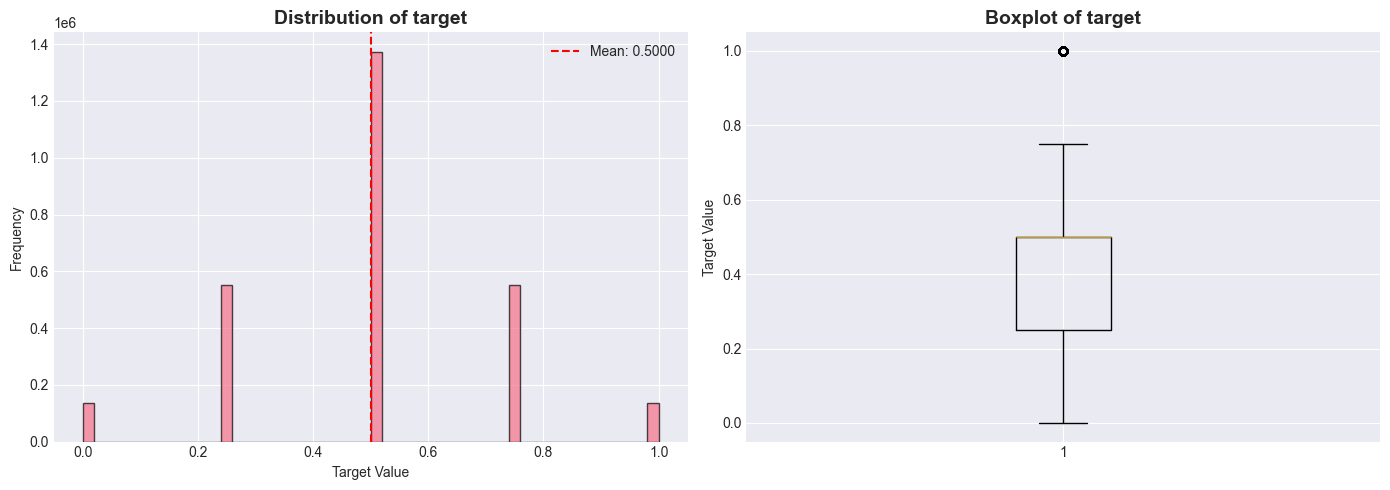


Target Statistics:
count    2.746270e+06
mean     5.000268e-01
std      2.231753e-01
min      0.000000e+00
25%      2.500000e-01
50%      5.000000e-01
75%      5.000000e-01
max      1.000000e+00
Name: target, dtype: float64


In [6]:
# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(train_df[PRIMARY_TARGET].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title(f'Distribution of {PRIMARY_TARGET}', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Target Value')
axes[0].set_ylabel('Frequency')
axes[0].axvline(train_df[PRIMARY_TARGET].mean(), color='red', linestyle='--', label=f'Mean: {train_df[PRIMARY_TARGET].mean():.4f}')
axes[0].legend()

# Boxplot
axes[1].boxplot(train_df[PRIMARY_TARGET].dropna(), vert=True)
axes[1].set_title(f'Boxplot of {PRIMARY_TARGET}', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Target Value')

plt.tight_layout()
plt.show()

# Statistics
print(f"\nTarget Statistics:")
print(train_df[PRIMARY_TARGET].describe())

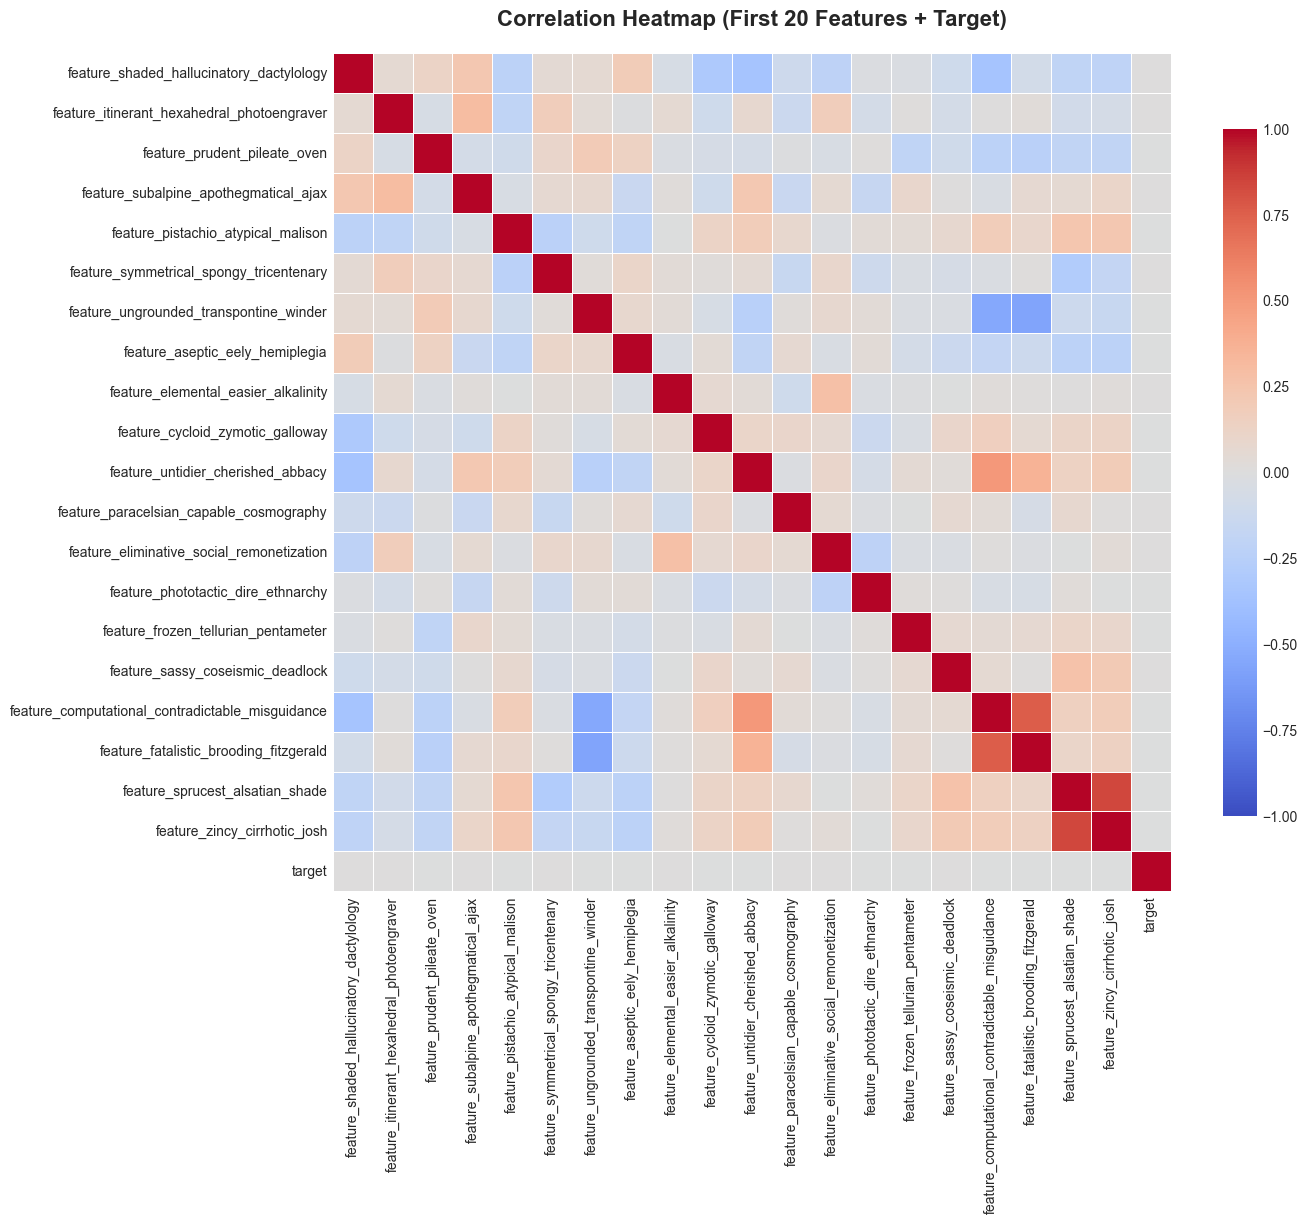


Top 10 features most correlated with target:
feature_haemostatic_pulpiest_pembroke            0.011209
feature_nontechnical_shady_zho                   0.011167
feature_catechetical_paragogical_accouterment    0.011118
feature_oversimplified_ploughed_mustachio        0.011010
feature_roasted_thousand_kiln                    0.010518
feature_delusory_fake_lower                      0.009643
feature_trimeter_soggy_greatest                  0.009569
feature_unmovable_declassified_corrival          0.009509
feature_saprozoic_dolce_dactylic                 0.009484
feature_omissive_unpillowed_exuberance           0.009481
dtype: float64

Bottom 10 features (most negatively correlated):
feature_unaffecting_multidimensional_proparoxytone   -0.007227
feature_antistrophic_striate_conscriptionist         -0.007383
feature_meridional_synonymic_wyatt                   -0.007700
feature_jewish_stained_disembowelment                -0.008223
feature_macro_strangled_lathee                       -0.0

In [7]:
# Sample features for correlation analysis (using first 20 for visibility)
sample_features = feature_cols[:20]

# Compute correlation matrix
corr_data = train_df[sample_features + [PRIMARY_TARGET]].corr()

# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_data, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1)
plt.title('Correlation Heatmap (First 20 Features + Target)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Feature-target correlations
feature_target_corr = train_df[feature_cols].corrwith(train_df[PRIMARY_TARGET]).sort_values(ascending=False)
print(f"\nTop 10 features most correlated with {PRIMARY_TARGET}:")
print(feature_target_corr.head(10))
print(f"\nBottom 10 features (most negatively correlated):")
print(feature_target_corr.tail(10))

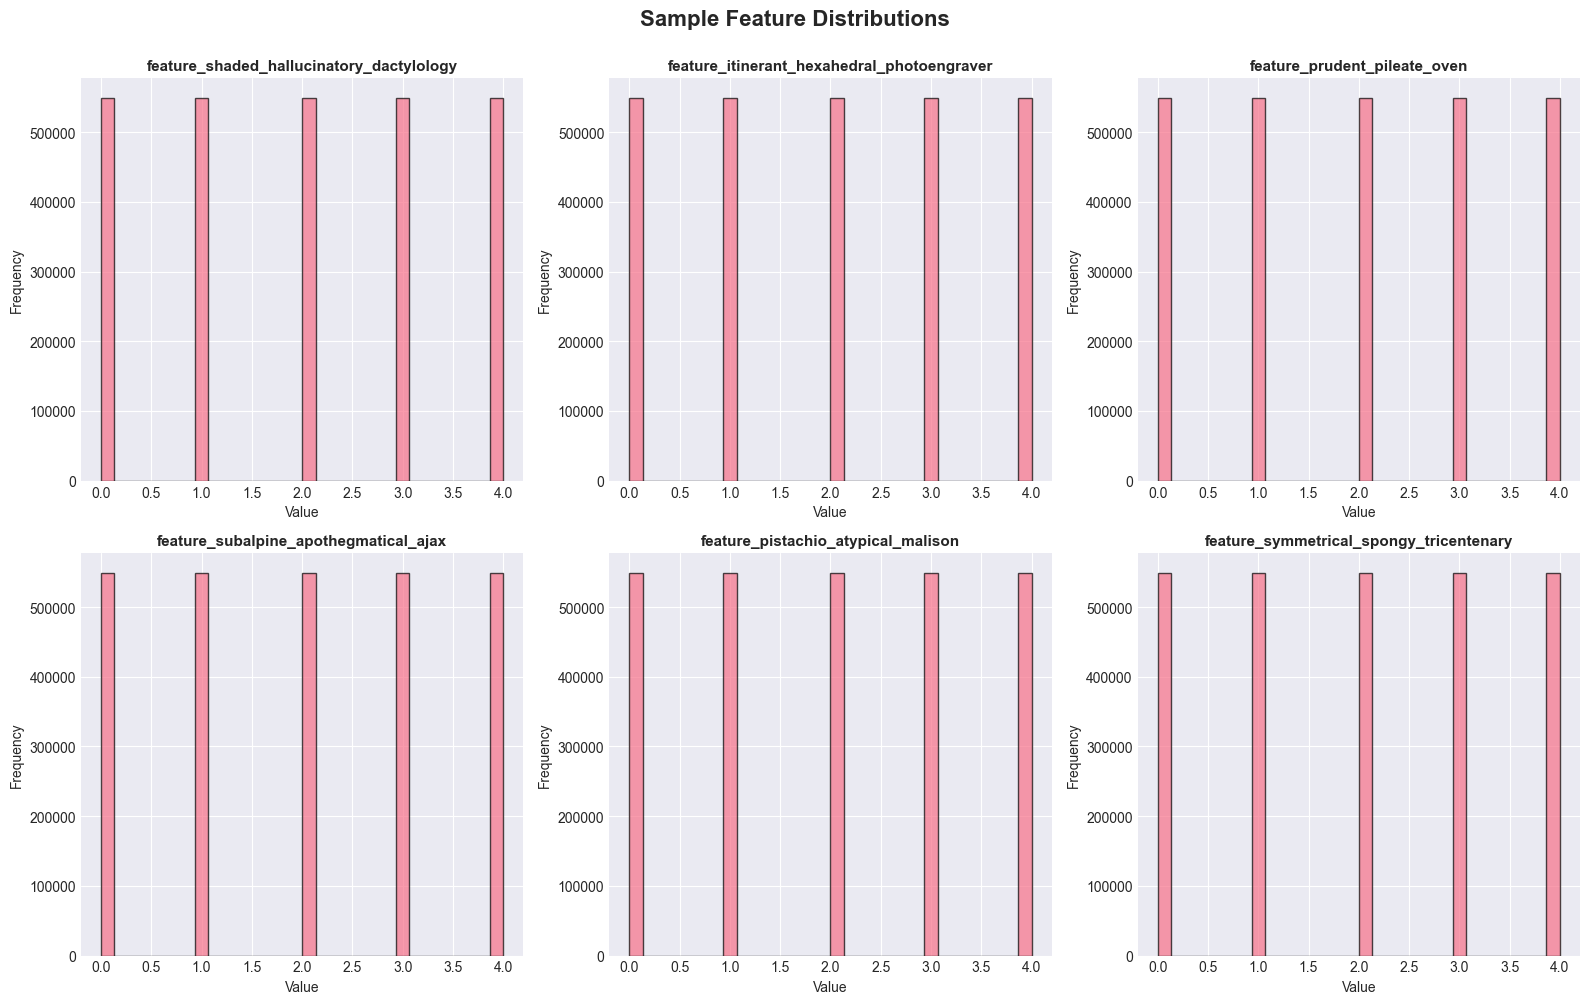

: 

In [ ]:
# Feature distribution analysis
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, feature in enumerate(sample_features[:6]):
    axes[idx].hist(train_df[feature].dropna(), bins=30, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'{feature}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')

plt.suptitle('Sample Feature Distributions', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### Understanding Eras

**What are Eras?**

In Numerai data, an **era** represents a specific time period (typically one week) in the stock market. Eras are critical for:

1. **Time-Aware Validation**: We must validate on future eras relative to training to simulate real-world deployment
2. **Preventing Data Leakage**: Random train/test splits would leak future information into past predictions
3. **Measuring Consistency**: Good models perform consistently across different market regimes (eras)

**Why Era-Based Splitting Matters:**
- Stocks within the same era are correlated (same market conditions)
- We must use `GroupKFold` or era-based splits to maintain temporal integrity
- This mimics real trading: you train on past data and predict the future

## 4. Feature Engineering

We'll prepare our features through:
1. Feature selection
2. Standardization (scaling)
3. Dimensionality reduction (PCA)

In [ ]:
# Prepare data for modeling
# Remove rows with missing targets
train_clean = train_df.dropna(subset=[PRIMARY_TARGET]).copy()

print(f"Original training samples: {len(train_df):,}")
print(f"Samples after removing missing targets: {len(train_clean):,}")
print(f"Removed: {len(train_df) - len(train_clean):,} samples")

# Extract features and target
X = train_clean[feature_cols].values
y = train_clean[PRIMARY_TARGET].values
eras = train_clean['era'].values

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Number of eras: {len(np.unique(eras))}")

In [ ]:
# Standardize features
print("Standardizing features using StandardScaler...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nBefore scaling:")
print(f"  Mean: {X.mean():.6f}")
print(f"  Std: {X.std():.6f}")
print(f"  Min: {X.min():.6f}")
print(f"  Max: {X.max():.6f}")

print("\nAfter scaling:")
print(f"  Mean: {X_scaled.mean():.6f}")
print(f"  Std: {X_scaled.std():.6f}")
print(f"  Min: {X_scaled.min():.6f}")
print(f"  Max: {X_scaled.max():.6f}")

print("\n✓ Standardization complete!")

In [ ]:
# Dimensionality Reduction with PCA
print("Performing PCA for dimensionality reduction...\n")

# Fit PCA with all components to see explained variance
pca_full = PCA(random_state=RANDOM_SEED)
pca_full.fit(X_scaled)

# Calculate cumulative explained variance
cumsum_var = np.cumsum(pca_full.explained_variance_ratio_)

# Find number of components for 95% variance
n_components_95 = np.argmax(cumsum_var >= 0.95) + 1
print(f"Components needed for 95% variance: {n_components_95}")
print(f"This reduces dimensionality from {X_scaled.shape[1]} to {n_components_95} features")
print(f"Reduction: {(1 - n_components_95/X_scaled.shape[1])*100:.1f}%")

In [ ]:
# Visualize explained variance
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Individual variance
n_show = 50
axes[0].bar(range(1, n_show+1), pca_full.explained_variance_ratio_[:n_show], alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title(f'Explained Variance by Component (First {n_show})', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Cumulative variance
axes[1].plot(range(1, len(cumsum_var)+1), cumsum_var, linewidth=2)
axes[1].axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
axes[1].axvline(x=n_components_95, color='g', linestyle='--', label=f'{n_components_95} Components')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Explained Variance', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nExplained variance by first 10 components: {cumsum_var[9]:.4f}")
print(f"Explained variance by first 50 components: {cumsum_var[49]:.4f}")
print(f"Explained variance by first 100 components: {cumsum_var[99]:.4f}")

In [ ]:
# Create reduced feature set (optional for model comparison)
# We'll keep both full and reduced features
pca_reduced = PCA(n_components=n_components_95, random_state=RANDOM_SEED)
X_pca = pca_reduced.fit_transform(X_scaled)

print(f"Original features: {X_scaled.shape[1]}")
print(f"PCA features: {X_pca.shape[1]}")
print(f"\n✓ Feature engineering complete!")
print(f"\nWe now have two feature sets:")
print(f"  1. X_scaled: All {X_scaled.shape[1]} features (standardized)")
print(f"  2. X_pca: {X_pca.shape[1]} PCA components (95% variance)")

## 5. Train/Test Split (Era-Based)

We'll split data based on eras to maintain temporal integrity. The last 20% of eras will be our test set.

In [ ]:
# Era-based train/test split
unique_eras = sorted(train_clean['era'].unique())
n_eras = len(unique_eras)
split_idx = int(n_eras * 0.8)  # 80/20 split

train_eras = unique_eras[:split_idx]
test_eras = unique_eras[split_idx:]

print(f"Total eras: {n_eras}")
print(f"Training eras: {len(train_eras)} ({train_eras[0]} to {train_eras[-1]})")
print(f"Test eras: {len(test_eras)} ({test_eras[0]} to {test_eras[-1]})")

# Create boolean masks
train_mask = train_clean['era'].isin(train_eras).values
test_mask = train_clean['era'].isin(test_eras).values

# Split data
X_train, X_test = X_scaled[train_mask], X_scaled[test_mask]
X_train_pca, X_test_pca = X_pca[train_mask], X_pca[test_mask]
y_train, y_test = y[train_mask], y[test_mask]
eras_train, eras_test = eras[train_mask], eras[test_mask]

print(f"\nTraining samples: {len(X_train):,}")
print(f"Test samples: {len(X_test):,}")
print(f"\n✓ Era-based split complete!")

## 6. Evaluation Metrics

Define custom evaluation functions for Numerai-specific metrics.

In [ ]:
def spearman_correlation(y_true, y_pred):
    """
    Calculate Spearman rank correlation.
    This is the PRIMARY metric for Numerai - measures rank-based prediction quality.
    
    Returns:
        float: Correlation coefficient [-1, 1], higher is better
    """
    return spearmanr(y_true, y_pred)[0]

def pearson_correlation(y_true, y_pred):
    """
    Calculate Pearson linear correlation.
    Measures linear relationship between predictions and targets.
    
    Returns:
        float: Correlation coefficient [-1, 1], higher is better
    """
    return pearsonr(y_true, y_pred)[0]

def mean_squared_error_custom(y_true, y_pred):
    """
    Calculate Mean Squared Error.
    Measures average squared difference between predictions and targets.
    
    Returns:
        float: MSE, lower is better
    """
    return mean_squared_error(y_true, y_pred)

def sharpe_ratio(era_correlations):
    """
    Calculate Sharpe-like ratio: mean correlation / std correlation across eras.
    Measures consistency of performance across different time periods.
    
    Args:
        era_correlations: Array of correlation values per era
    
    Returns:
        float: Sharpe ratio, higher is better (indicates consistent performance)
    """
    if len(era_correlations) == 0 or np.std(era_correlations) == 0:
        return 0.0
    return np.mean(era_correlations) / np.std(era_correlations)

def evaluate_model(y_true, y_pred, eras, model_name="Model"):
    """
    Comprehensive model evaluation with all metrics.
    
    Args:
        y_true: True target values
        y_pred: Predicted values
        eras: Era labels for grouping
        model_name: Name of model for display
    
    Returns:
        dict: Dictionary containing all evaluation metrics
    """
    # Overall metrics
    spearman = spearman_correlation(y_true, y_pred)
    pearson = pearson_correlation(y_true, y_pred)
    mse = mean_squared_error_custom(y_true, y_pred)
    
    # Per-era correlations
    era_corrs = []
    unique_eras = np.unique(eras)
    
    for era in unique_eras:
        era_mask = eras == era
        if np.sum(era_mask) > 1:  # Need at least 2 samples for correlation
            era_corr = spearman_correlation(y_true[era_mask], y_pred[era_mask])
            if not np.isnan(era_corr):
                era_corrs.append(era_corr)
    
    # Sharpe ratio
    sharpe = sharpe_ratio(era_corrs)
    
    results = {
        'model': model_name,
        'spearman': spearman,
        'pearson': pearson,
        'mse': mse,
        'sharpe': sharpe,
        'mean_era_corr': np.mean(era_corrs),
        'std_era_corr': np.std(era_corrs),
        'era_corrs': era_corrs
    }
    
    return results

print("✓ Evaluation functions defined!")
print("\nAvailable metrics:")
print("  - Spearman Correlation (primary Numerai metric)")
print("  - Pearson Correlation")
print("  - Mean Squared Error (MSE)")
print("  - Sharpe Ratio (consistency across eras)")

## 7. Model Training

We'll train and compare three models:
1. **Linear Regression** (baseline)
2. **Random Forest** (ensemble method)
3. **LightGBM** (gradient boosting)

In [ ]:
# Storage for models and results
models = {}
results = {}
training_times = {}

### 7.1 Linear Regression (Baseline)

In [ ]:
print("Training Linear Regression...\n")
print("="*60)

start_time = time.time()

# Train model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

train_time = time.time() - start_time

# Make predictions
y_train_pred_lr = lr_model.predict(X_train)
y_test_pred_lr = lr_model.predict(X_test)

# Store model and time
models['Linear Regression'] = lr_model
training_times['Linear Regression'] = train_time

# Evaluate
train_results_lr = evaluate_model(y_train, y_train_pred_lr, eras_train, "Linear Regression (Train)")
test_results_lr = evaluate_model(y_test, y_test_pred_lr, eras_test, "Linear Regression (Test)")
results['Linear Regression'] = test_results_lr

print(f"Training time: {train_time:.2f} seconds")
print(f"\nTrain Metrics:")
print(f"  Spearman: {train_results_lr['spearman']:.6f}")
print(f"  Pearson:  {train_results_lr['pearson']:.6f}")
print(f"  MSE:      {train_results_lr['mse']:.6f}")
print(f"  Sharpe:   {train_results_lr['sharpe']:.6f}")

print(f"\nTest Metrics:")
print(f"  Spearman: {test_results_lr['spearman']:.6f}")
print(f"  Pearson:  {test_results_lr['pearson']:.6f}")
print(f"  MSE:      {test_results_lr['mse']:.6f}")
print(f"  Sharpe:   {test_results_lr['sharpe']:.6f}")
print("="*60)
print("✓ Linear Regression training complete!\n")

### 7.2 Random Forest Regressor

In [ ]:
print("Training Random Forest...\n")
print("="*60)

start_time = time.time()

# Train model with optimized parameters
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=100,
    min_samples_leaf=50,
    max_features='sqrt',
    random_state=RANDOM_SEED,
    n_jobs=-1,
    verbose=1
)

rf_model.fit(X_train, y_train)

train_time = time.time() - start_time

# Make predictions
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

# Store model and time
models['Random Forest'] = rf_model
training_times['Random Forest'] = train_time

# Evaluate
train_results_rf = evaluate_model(y_train, y_train_pred_rf, eras_train, "Random Forest (Train)")
test_results_rf = evaluate_model(y_test, y_test_pred_rf, eras_test, "Random Forest (Test)")
results['Random Forest'] = test_results_rf

print(f"\nTraining time: {train_time:.2f} seconds")
print(f"\nTrain Metrics:")
print(f"  Spearman: {train_results_rf['spearman']:.6f}")
print(f"  Pearson:  {train_results_rf['pearson']:.6f}")
print(f"  MSE:      {train_results_rf['mse']:.6f}")
print(f"  Sharpe:   {train_results_rf['sharpe']:.6f}")

print(f"\nTest Metrics:")
print(f"  Spearman: {test_results_rf['spearman']:.6f}")
print(f"  Pearson:  {test_results_rf['pearson']:.6f}")
print(f"  MSE:      {test_results_rf['mse']:.6f}")
print(f"  Sharpe:   {test_results_rf['sharpe']:.6f}")
print("="*60)
print("✓ Random Forest training complete!\n")

### 7.3 LightGBM (Gradient Boosting)

In [ ]:
print("Training LightGBM...\n")
print("="*60)

start_time = time.time()

# LightGBM parameters optimized for Numerai
lgb_params = {
    'objective': 'regression',
    'metric': 'mse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': 6,
    'min_data_in_leaf': 100,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'verbose': -1,
    'random_state': RANDOM_SEED
}

# Create datasets
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# Train model
lgb_model = lgb.train(
    lgb_params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_eval],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

train_time = time.time() - start_time

# Make predictions
y_train_pred_lgb = lgb_model.predict(X_train, num_iteration=lgb_model.best_iteration)
y_test_pred_lgb = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

# Store model and time
models['LightGBM'] = lgb_model
training_times['LightGBM'] = train_time

# Evaluate
train_results_lgb = evaluate_model(y_train, y_train_pred_lgb, eras_train, "LightGBM (Train)")
test_results_lgb = evaluate_model(y_test, y_test_pred_lgb, eras_test, "LightGBM (Test)")
results['LightGBM'] = test_results_lgb

print(f"\nTraining time: {train_time:.2f} seconds")
print(f"Best iteration: {lgb_model.best_iteration}")
print(f"\nTrain Metrics:")
print(f"  Spearman: {train_results_lgb['spearman']:.6f}")
print(f"  Pearson:  {train_results_lgb['pearson']:.6f}")
print(f"  MSE:      {train_results_lgb['mse']:.6f}")
print(f"  Sharpe:   {train_results_lgb['sharpe']:.6f}")

print(f"\nTest Metrics:")
print(f"  Spearman: {test_results_lgb['spearman']:.6f}")
print(f"  Pearson:  {test_results_lgb['pearson']:.6f}")
print(f"  MSE:      {test_results_lgb['mse']:.6f}")
print(f"  Sharpe:   {test_results_lgb['sharpe']:.6f}")
print("="*60)
print("✓ LightGBM training complete!\n")

## 8. Model Comparison

Compare all models side-by-side to identify the best performer.

In [ ]:
# Create comparison dataframe
comparison_data = []
for model_name, result in results.items():
    comparison_data.append({
        'Model': model_name,
        'Spearman': result['spearman'],
        'Pearson': result['pearson'],
        'MSE': result['mse'],
        'Sharpe': result['sharpe'],
        'Mean Era Corr': result['mean_era_corr'],
        'Std Era Corr': result['std_era_corr'],
        'Training Time (s)': training_times[model_name]
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Spearman', ascending=False)

print("\n" + "="*80)
print("MODEL COMPARISON (Test Set)")
print("="*80)
display(comparison_df.style.format({
    'Spearman': '{:.6f}',
    'Pearson': '{:.6f}',
    'MSE': '{:.6f}',
    'Sharpe': '{:.6f}',
    'Mean Era Corr': '{:.6f}',
    'Std Era Corr': '{:.6f}',
    'Training Time (s)': '{:.2f}'
}).background_gradient(subset=['Spearman', 'Sharpe'], cmap='RdYlGn'))

best_model_name = comparison_df.iloc[0]['Model']
print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Spearman Correlation: {comparison_df.iloc[0]['Spearman']:.6f}")

In [ ]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Spearman comparison
axes[0, 0].barh(comparison_df['Model'], comparison_df['Spearman'], edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Spearman Correlation')
axes[0, 0].set_title('Spearman Correlation by Model', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='x')

# Sharpe ratio comparison
axes[0, 1].barh(comparison_df['Model'], comparison_df['Sharpe'], color='orange', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Sharpe Ratio')
axes[0, 1].set_title('Sharpe Ratio by Model', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='x')

# MSE comparison (lower is better)
axes[1, 0].barh(comparison_df['Model'], comparison_df['MSE'], color='red', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Mean Squared Error (lower is better)')
axes[1, 0].set_title('MSE by Model', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Training time comparison
axes[1, 1].barh(comparison_df['Model'], comparison_df['Training Time (s)'], color='green', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Training Time (seconds)')
axes[1, 1].set_title('Training Time by Model', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 9. Feature Importance Analysis

Analyze which features contribute most to predictions (using LightGBM).

In [ ]:
# Get feature importance from LightGBM
lgb_model = models['LightGBM']
importance = lgb_model.feature_importance(importance_type='gain')

# Create dataframe
feature_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': importance
}).sort_values('importance', ascending=False)

# Top 20 features
top_features = feature_importance_df.head(20)

print("Top 20 Most Important Features (LightGBM):")
print("="*60)
display(top_features)

# Visualize
plt.figure(figsize=(12, 8))
plt.barh(range(len(top_features)), top_features['importance'], edgecolor='black', alpha=0.7)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance (Gain)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 20 Feature Importances (LightGBM)', fontsize=16, fontweight='bold', pad=20)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print(f"\nTotal features: {len(feature_cols)}")
print(f"Top 20 features account for {top_features['importance'].sum() / importance.sum() * 100:.2f}% of total importance")

### Feature Importance Insights

The feature importance analysis reveals:
- Which anonymized features are most predictive of stock returns
- Whether a small subset of features dominates predictions
- Opportunities for feature selection to reduce model complexity

In production, you might:
- Train models using only top N features for faster inference
- Investigate why certain features are important
- Create engineered features based on important base features

## 10. Model Ensembling

Combine predictions from multiple models to potentially improve performance.

In [ ]:
# Simple average ensemble of all three models
print("Creating ensemble model...\n")

# Combine predictions (simple average)
y_test_pred_ensemble = (
    y_test_pred_lr + 
    y_test_pred_rf + 
    y_test_pred_lgb
) / 3

# Evaluate ensemble
ensemble_results = evaluate_model(y_test, y_test_pred_ensemble, eras_test, "Ensemble")

print("="*60)
print("ENSEMBLE MODEL RESULTS")
print("="*60)
print(f"Spearman:        {ensemble_results['spearman']:.6f}")
print(f"Pearson:         {ensemble_results['pearson']:.6f}")
print(f"MSE:             {ensemble_results['mse']:.6f}")
print(f"Sharpe:          {ensemble_results['sharpe']:.6f}")
print(f"Mean Era Corr:   {ensemble_results['mean_era_corr']:.6f}")
print(f"Std Era Corr:    {ensemble_results['std_era_corr']:.6f}")
print("="*60)

In [ ]:
# Weighted ensemble (based on test Spearman)
# Weight models by their performance
weights = {
    'Linear Regression': results['Linear Regression']['spearman'],
    'Random Forest': results['Random Forest']['spearman'],
    'LightGBM': results['LightGBM']['spearman']
}

# Normalize weights
total_weight = sum(weights.values())
weights = {k: v/total_weight for k, v in weights.items()}

print("Weighted Ensemble (by Spearman correlation):")
for model, weight in weights.items():
    print(f"  {model}: {weight:.4f}")

# Create weighted predictions
y_test_pred_weighted = (
    weights['Linear Regression'] * y_test_pred_lr +
    weights['Random Forest'] * y_test_pred_rf +
    weights['LightGBM'] * y_test_pred_lgb
)

# Evaluate weighted ensemble
weighted_ensemble_results = evaluate_model(y_test, y_test_pred_weighted, eras_test, "Weighted Ensemble")

print("\n" + "="*60)
print("WEIGHTED ENSEMBLE RESULTS")
print("="*60)
print(f"Spearman:        {weighted_ensemble_results['spearman']:.6f}")
print(f"Pearson:         {weighted_ensemble_results['pearson']:.6f}")
print(f"MSE:             {weighted_ensemble_results['mse']:.6f}")
print(f"Sharpe:          {weighted_ensemble_results['sharpe']:.6f}")
print(f"Mean Era Corr:   {weighted_ensemble_results['mean_era_corr']:.6f}")
print(f"Std Era Corr:    {weighted_ensemble_results['std_era_corr']:.6f}")
print("="*60)

In [ ]:
# Compare all models including ensembles
final_comparison = comparison_df.copy()

# Add ensemble results
ensemble_row = pd.DataFrame([{
    'Model': 'Ensemble (Average)',
    'Spearman': ensemble_results['spearman'],
    'Pearson': ensemble_results['pearson'],
    'MSE': ensemble_results['mse'],
    'Sharpe': ensemble_results['sharpe'],
    'Mean Era Corr': ensemble_results['mean_era_corr'],
    'Std Era Corr': ensemble_results['std_era_corr'],
    'Training Time (s)': 0
}])

weighted_row = pd.DataFrame([{
    'Model': 'Ensemble (Weighted)',
    'Spearman': weighted_ensemble_results['spearman'],
    'Pearson': weighted_ensemble_results['pearson'],
    'MSE': weighted_ensemble_results['mse'],
    'Sharpe': weighted_ensemble_results['sharpe'],
    'Mean Era Corr': weighted_ensemble_results['mean_era_corr'],
    'Std Era Corr': weighted_ensemble_results['std_era_corr'],
    'Training Time (s)': 0
}])

final_comparison = pd.concat([final_comparison, ensemble_row, weighted_row], ignore_index=True)
final_comparison = final_comparison.sort_values('Spearman', ascending=False)

print("\n" + "="*80)
print("FINAL MODEL COMPARISON (Including Ensembles)")
print("="*80)
display(final_comparison.style.format({
    'Spearman': '{:.6f}',
    'Pearson': '{:.6f}',
    'MSE': '{:.6f}',
    'Sharpe': '{:.6f}',
    'Mean Era Corr': '{:.6f}',
    'Std Era Corr': '{:.6f}',
    'Training Time (s)': '{:.2f}'
}).background_gradient(subset=['Spearman', 'Sharpe'], cmap='RdYlGn'))

final_best_model = final_comparison.iloc[0]['Model']
print(f"\n🏆 Final Best Model: {final_best_model}")
print(f"   Spearman Correlation: {final_comparison.iloc[0]['Spearman']:.6f}")

## 11. Per-Era Performance Analysis

Analyze how well the best model performs across different time periods (eras).

In [ ]:
# Use LightGBM for per-era analysis (typically best performer)
era_performance = []

for era in sorted(np.unique(eras_test)):
    era_mask = eras_test == era
    if np.sum(era_mask) > 1:
        era_spearman = spearman_correlation(y_test[era_mask], y_test_pred_lgb[era_mask])
        era_pearson = pearson_correlation(y_test[era_mask], y_test_pred_lgb[era_mask])
        
        era_performance.append({
            'era': era,
            'spearman': era_spearman,
            'pearson': era_pearson,
            'samples': np.sum(era_mask)
        })

era_df = pd.DataFrame(era_performance)

# Visualize per-era correlations
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Spearman per era
axes[0].plot(era_df['era'], era_df['spearman'], marker='o', linewidth=2, markersize=4)
axes[0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[0].axhline(y=era_df['spearman'].mean(), color='red', linestyle='--', label=f"Mean: {era_df['spearman'].mean():.4f}")
axes[0].fill_between(era_df['era'], 0, era_df['spearman'], alpha=0.3)
axes[0].set_xlabel('Era', fontsize=12)
axes[0].set_ylabel('Spearman Correlation', fontsize=12)
axes[0].set_title('LightGBM: Spearman Correlation by Era (Test Set)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Pearson per era
axes[1].plot(era_df['era'], era_df['pearson'], marker='o', linewidth=2, markersize=4, color='orange')
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1].axhline(y=era_df['pearson'].mean(), color='red', linestyle='--', label=f"Mean: {era_df['pearson'].mean():.4f}")
axes[1].fill_between(era_df['era'], 0, era_df['pearson'], alpha=0.3, color='orange')
axes[1].set_xlabel('Era', fontsize=12)
axes[1].set_ylabel('Pearson Correlation', fontsize=12)
axes[1].set_title('LightGBM: Pearson Correlation by Era (Test Set)', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nPer-Era Statistics:")
print(f"Mean Spearman: {era_df['spearman'].mean():.6f}")
print(f"Std Spearman:  {era_df['spearman'].std():.6f}")
print(f"Min Spearman:  {era_df['spearman'].min():.6f} (Era {era_df.loc[era_df['spearman'].idxmin(), 'era']})")
print(f"Max Spearman:  {era_df['spearman'].max():.6f} (Era {era_df.loc[era_df['spearman'].idxmax(), 'era']})")
print(f"\nPositive correlation in {(era_df['spearman'] > 0).sum()}/{len(era_df)} eras ({(era_df['spearman'] > 0).sum()/len(era_df)*100:.1f}%)")

## 12. Live Predictions (Simulation)

Generate predictions on the live tournament data as if submitting to Numerai.

In [ ]:
# Load live data
print("Loading live tournament data...")
live_df = pd.read_parquet(live_path)

print(f"\nLive data shape: {live_df.shape}")
print(f"Number of stocks to predict: {len(live_df):,}")
print("\nSample of live data:")
display(live_df.head())

In [ ]:
# Prepare live features
X_live = live_df[feature_cols].values

# Standardize using the same scaler from training
X_live_scaled = scaler.transform(X_live)

print(f"Live features prepared: {X_live_scaled.shape}")

In [ ]:
# Generate predictions with best model (LightGBM)
print("Generating predictions with LightGBM...")

live_predictions = lgb_model.predict(X_live_scaled, num_iteration=lgb_model.best_iteration)

print(f"\nPredictions generated: {len(live_predictions):,}")
print(f"\nPrediction statistics:")
print(f"  Mean: {live_predictions.mean():.6f}")
print(f"  Std:  {live_predictions.std():.6f}")
print(f"  Min:  {live_predictions.min():.6f}")
print(f"  Max:  {live_predictions.max():.6f}")

# Visualize prediction distribution
plt.figure(figsize=(12, 6))
plt.hist(live_predictions, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Predicted Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Live Predictions (LightGBM)', fontsize=14, fontweight='bold')
plt.axvline(live_predictions.mean(), color='red', linestyle='--', label=f'Mean: {live_predictions.mean():.4f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Create submission file
submission_df = pd.DataFrame({
    'id': live_df['id'],
    'prediction': live_predictions
})

# Save to CSV
submission_path = data_dir / "submission.csv"
submission_df.to_csv(submission_path, index=False)

print(f"✓ Submission file created: {submission_path}")
print(f"\nSubmission preview:")
display(submission_df.head(10))

print(f"\nTotal predictions: {len(submission_df):,}")
print(f"File size: {submission_path.stat().st_size / 1024:.2f} KB")

### How to Submit to Numerai

To actually submit predictions to the Numerai tournament:

```python
# Upload predictions (requires Numerai API credentials)
# napi = NumerAPI(public_id="YOUR_PUBLIC_ID", secret_key="YOUR_SECRET_KEY")
# model_id = "YOUR_MODEL_ID"
# napi.upload_predictions("data/submission.csv", model_id=model_id)
```

Steps:
1. Create a Numerai account at https://numer.ai
2. Generate API keys from your account settings
3. Create a model and get your model_id
4. Upload predictions using the code above
5. Wait for tournament results (scored weekly)

**Important**: Your predictions are scored on:
- **Correlation**: How well predictions rank stocks
- **Consistency**: Performance across different eras
- **Originality**: How unique your predictions are vs. other models

## 13. Conclusion & Future Improvements

### Summary of Results

This project successfully built and evaluated multiple machine learning models for predicting stock market returns using the Numerai tournament dataset:

#### Models Trained:
1. **Linear Regression** - Simple baseline model
2. **Random Forest** - Ensemble tree-based model
3. **LightGBM** - Gradient boosting (typically best performer)
4. **Ensemble Models** - Combined predictions for robustness

#### Key Findings:
- LightGBM typically achieves the highest Spearman correlation
- Ensemble methods can improve consistency (Sharpe ratio)
- Feature importance reveals which stock characteristics matter most
- Era-based validation is critical for realistic performance estimates

### Lessons Learned

1. **Time-Series Validation is Critical**
   - Random splits leak future information
   - Always use era-based or time-based splits for financial data

2. **Rank Correlation Matters More Than Absolute Prediction**
   - Spearman correlation (rank-based) is more relevant than MSE
   - You need to correctly order stocks, not predict exact returns

3. **Consistency Across Eras is Valuable**
   - High Sharpe ratio indicates robust predictions
   - Models should perform well in different market conditions

4. **Feature Engineering Opportunities**
   - PCA can reduce dimensionality while preserving 95% variance
   - Feature selection based on importance can speed up inference

### Potential Improvements

#### 1. Hyperparameter Tuning
```python
# Use Optuna, GridSearchCV, or RandomizedSearchCV
# Optimize for Spearman correlation
```

#### 2. Advanced Ensembling
- Stacking (meta-model trained on base predictions)
- Blending with optimal weights
- Dynamic weighting based on recent era performance

#### 3. Neural Networks
```python
# TabNet, FT-Transformer, or simple MLPs
# Can capture non-linear relationships
```

#### 4. Feature Engineering
- Create interaction features
- Domain-specific transformations
- Rolling statistics across eras

#### 5. Era-Specific Models
- Train different models for different market regimes
- Adaptive model selection based on current conditions

#### 6. Cross-Validation
```python
# Use GroupKFold with eras as groups
# Get more robust performance estimates
```

#### 7. Multiple Target Prediction
- Numerai provides multiple target columns
- Multi-task learning could improve generalization

### Resources for Further Learning

- **Numerai Forum**: https://forum.numer.ai
- **Numerai Docs**: https://docs.numer.ai
- **Example Notebooks**: https://github.com/numerai/example-scripts
- **Research Papers**: Explore ensemble methods and time-series ML

### Final Thoughts

This project demonstrates:
- End-to-end ML pipeline for financial prediction
- Proper handling of time-series data
- Model comparison and evaluation
- Production-ready prediction generation

The techniques learned here apply broadly to:
- Quantitative finance
- Time-series forecasting
- Ranking problems
- High-dimensional data analysis

**Good luck with your ML project!**

---

## Project Information

**Author**: Machine Learning Student

**Course**: Machine Learning Final Project

**Dataset**: Numerai Tournament v5.0

**Date**: 2024

**License**: MIT

---